# Example: EDI-Vetter Unplugged tool for WASP 18b
## (~0.94 day Period, ~13 Earth Radii Radius)

Begin by importing the necessary packages. This tutorial was written by [Dax Feliz](https://daxfeliz.github.io) and designed to run independently. Thus, it includeds all the steps needed to download the light curve photometry, search for a transit signal, and finally vet the detected signal. 

In [1]:
import EDIunplugged as EDI
import lightkurve as lk

import os,sys
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
pd.set_option('display.notebook_repr_html', True)

#pipeline settings
path=os.getcwd()+'/'

Here, we will import the TESS PDCSAP flux data using lightkurve.

In [19]:
import lightkurve as lk
lk.log.setLevel('INFO')

ID=100100827; Sector=2

#save to local directory
downloadpath=os.getcwd()+'/'

target='TIC '+str(ID)
lc_2min=lk.search.search_lightcurve(target, cadence='short', mission=("TESS"),sector=Sector).download_all(download_dir=downloadpath)
lc_2min_precut=lc_2min[0].remove_nans().normalize()

2% (399/18699) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


To make sure we have a nice clear light curve we will apply a quality mask, removing data that has been flagged as problematic, then plot the resulting photometry.

Text(0.5, 1.0, 'TIC 100100827 Sector 2')

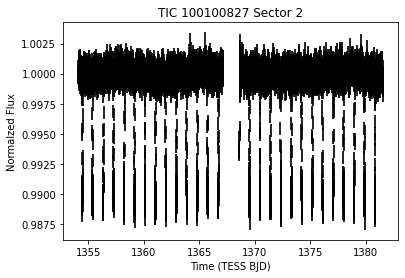

In [26]:
q = lc_2min_precut.quality!=0
lc_2min = lk.LightCurve(time=lc_2min_precut.time[~q],flux=lc_2min_precut.flux[~q],flux_err=lc_2min_precut.flux_err[~q])
#plot
plt.errorbar(x=np.array(lc_2min_precut.time.value),y=np.array(lc_2min_precut.flux.value),yerr=np.array(lc_2min_precut.flux_err.value),color='grey',linestyle='none')
plt.errorbar(x=np.array(lc_2min.time.value),y=np.array(lc_2min.flux.value),yerr=np.array(lc_2min.flux_err.value),color='black',linestyle='none')
plt.xlabel('Time (TESS BJD)')
plt.ylabel('Normalzed Flux')
plt.title('TIC '+str(ID)+' Sector '+str(Sector))

Save the output to a CSV file

In [30]:
#saving in current working directory
input_LC = pd.DataFrame({'Time':lc_2min.time.value, 'SAP Flux':lc_2min.flux.value, 'SAP Error':lc_2min.flux_err.value})
input_LC.to_csv(os.getcwd()+'/TIC_'+str(ID)+'_Sector_'+str(Sector)+'_SPOC_LC.csv')

Pull the stellar paramters from the TIC using TLS

In [31]:
from transitleastsquares import catalog_info    
qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)

Use the stellar parameters and photometry to run a TLS search for the highest power signal.

In [32]:
known_period = 0.94124 #WASP 18b
known_period2 = 2.1558 #WASP 18c

time=input_LC['Time']
flux=input_LC['SAP Flux']
error=input_LC['SAP Error']

from transitleastsquares import transitleastsquares

#input parameters
N_transits=3
minP=0.5

tls = transitleastsquares(time,flux,error)

tls_power = tls.power(R_star_min=R_star-R_star_min, R_star_max=R_star+R_star_max,R_star=R_star,\
                                  M_star_min=M_star-M_star_min, M_star_max=M_star+M_star_max, M_star=M_star,\
                                  u=qld, period_min=minP)


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 18299 data points, 1635 periods from 0.857 to 13.703 days
Using all 10 CPU threads


100%|██████████████████████████████████████████| 1635/1635 periods | 00:04<00:00


Searching for best T0 for period 0.94118 days


We can now fold the light curve according to the TLS search period (0.9411785079640015 days) and visualize the resulting transit signal.

 
TIC 100100827 Sector 2
Period: 0.9411785079640015
Transit Count:  29


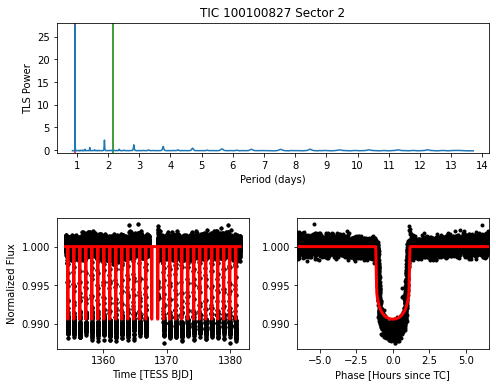

In [34]:
print(' ')
print('TIC '+str(ID)+' Sector '+str(Sector))
print('Period: '+str(tls_power.period))
print('Transit Count: ',tls_power.transit_count)


def phasefold(T0,time,period,flux):
    phase=(time- T0 + 0.5*period) % period - 0.5*period        
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]


ModelT=tls_power.model_lightcurve_time 
ModelF=tls_power.model_lightcurve_model

#phase folding LC and TLS model
pf,ff  = phasefold(tls_power.T0, time, tls_power.period,flux)
pf_model,ff_model = phasefold(ModelT,tls_power.T0,tls_power.period,ModelF)

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)
###
###
fig = plt.figure(figsize=(10,6))        
ax1 = fig.add_subplot(gs1[0:1, 0:2])
ax2 = fig.add_subplot(gs1[1:, 0:1])
ax3 = fig.add_subplot(gs1[1:, 1:2])


ax1.plot(tls_power.periods, tls_power.power, rasterized=True)
ax1.axvline(x=known_period,color='red',zorder=-1)
ax1.axvline(x=known_period2,color='green',zorder=-1)
ax1.set_title("TIC "+str(ID)+" "+"Sector "+str(Sector))#" Camera "+Camera+" CCD "+CCD)
ax1.set_xlabel("Period (days)")
ax1.set_xticks(np.arange(0.0, 15.0, 1.0))
ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)
###
ax1.set_ylabel("TLS Power")
ax1.set_ylim(np.min(tls_power.power)-0.5, np.max(tls_power.power)+0.5)

ax2.plot(time,flux,'k.')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Time [TESS BJD]')
ax2.plot(time,flux,'k.')
ax2.plot(ModelT,ModelF,'r-',linewidth=3)

ax3.plot(24*pf,ff,'k.')
ax3.plot(24*pf_model,ff_model,'r-',linewidth=3)
ax3.set_xlim(-3*24*tls_power.duration,3*24*tls_power.duration)
ax3.set_xlabel('Phase [Hours since TC]')
fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_SPOC_TLS_result.png',bbox_inches='tight')


## Running EDI-Vetter Unplugged

Upon visual inspection, this signal looks real. We should, therefore, expect EDI-Vetter Unplugged to produce a negative false positive classification. Let's now run it and see.

In [35]:
params=EDI.parameters(tls_power, limbDark=[qld[0], qld[1]], impact=0, snrThreshold=6, minTransit=N_transits)
EDI.Go(params, telescope='TESS')


 ___________ _____      _   _      _   _
|  ___|  _  \_   _|    | | | |    | | | |
| |__ | | | | | |______| | | | ___| |_| |_ ___ _ __
|  __|| | | | | |______| | | |/ _ \ __| __/ _ \ '__|
| |___| |/ / _| |_     \ \_/ /  __/ |_| ||  __/ |
\____/|___/  \___/      \___/ \___|\__|\__\___|_|   Unplugged
    
Version 0.1.3 (23 October 2020)
            Vetting Report
        Flux Contamination : False
         Too Many Outliers : False
  Too Many Transits Masked : False
Odd/Even Transit Variation : False
      Signal is not Unique : False
   Secondary Eclipse Found : False
Low Transit Phase Coverage : False
 Transit Duration Too Long : False
Signal is a False Positive : False


As suspected, this clear transit singal passes all the metrics and EDI-Vetter Unplugged is able to identify this transit signal correctly.